Create paths for input and output data:

In [1]:
import os

path_liver = "data/liver/raw"
if not os.path.exists(path_liver):
    os.makedirs(path_liver, exist_ok=True)

path_results = "data/liver/results"
if not os.path.exists(path_results):
    os.makedirs(path_results, exist_ok=True)

Copy raw data into appropriate subfolder of working directory and convert to the right name/format to be read by scanpy:

In [ ]:
import shutil

# download: https://www.ebi.ac.uk/biostudies/ArrayExpress/studies/E-MTAB-11530
filename="raw_scRNAseq_10X_precision_toxicology_combined_annotated_sep21.h5ad"
path_download = "Downloads/"

path_final = os.path.join(path_liver, filename)
if not os.path.exists(path_final):
    file = os.path.join(path_download, filename)
    shutil.move(file, path_liver)

Import necessary modules and set basic settings:

In [3]:
import numpy as np
import scanpy as sc
import seaborn as sns
from scipy.stats import median_abs_deviation

sc.settings.verbosity = 0
sc.settings.set_figure_params(
    dpi=80,
    facecolor="white",
    frameon=False,
)

Read in the data from the .h5ad file:

In [4]:
adata = sc.read_h5ad(path_final)
adata

AnnData object with n_obs × n_vars = 63527 × 19971
    obs: 'Age', 'Treatment', 'batch', 'sample_id', 'sample_name', 'n_counts', 'log_counts', 'n_genes', 'mt_fraction', 'replicate', 'subtype', 'subtype2', 'shared_clusters', 'donor_louvain', 'shared_clusters_sanity_check'
    var: 'gene_name'

Label any mitochondrial, ribosomal, or hemoglobin genes

In [5]:
# mitochondrial genes
adata.var['mt'] = adata.var_names.str.startswith('MT-') 
# ribosomal genes
adata.var['ribo'] = adata.var_names.str.startswith(("RPS","RPL"))
# hemoglobin genes.
adata.var['hb'] = adata.var_names.str.contains(("^HB[^(P|E|S)]"))

adata.var

,gene_name,mt,ribo,hb
OR4F5,OR4F5,False,False,False
OR4F29,OR4F29,False,False,False
OR4F16,OR4F16,False,False,False
SAMD11,SAMD11,False,False,False
NOC2L,NOC2L,False,False,False
...,...,...,...,...
AC141272.1,AC141272.1,False,False,False
AC023491.2,AC023491.2,False,False,False
AC007325.1,AC007325.1,False,False,False
AC007325.4,AC007325.4,False,False,False


Calculate qc metrics

In [6]:
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt','ribo','hb'], inplace=True, percent_top=[20], log1p=True
)
adata

AnnData object with n_obs × n_vars = 63527 × 19971
    obs: 'Age', 'Treatment', 'batch', 'sample_id', 'sample_name', 'n_counts', 'log_counts', 'n_genes', 'mt_fraction', 'replicate', 'subtype', 'subtype2', 'shared_clusters', 'donor_louvain', 'shared_clusters_sanity_check', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb'
    var: 'gene_name', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'

Plot qc values as violin plots

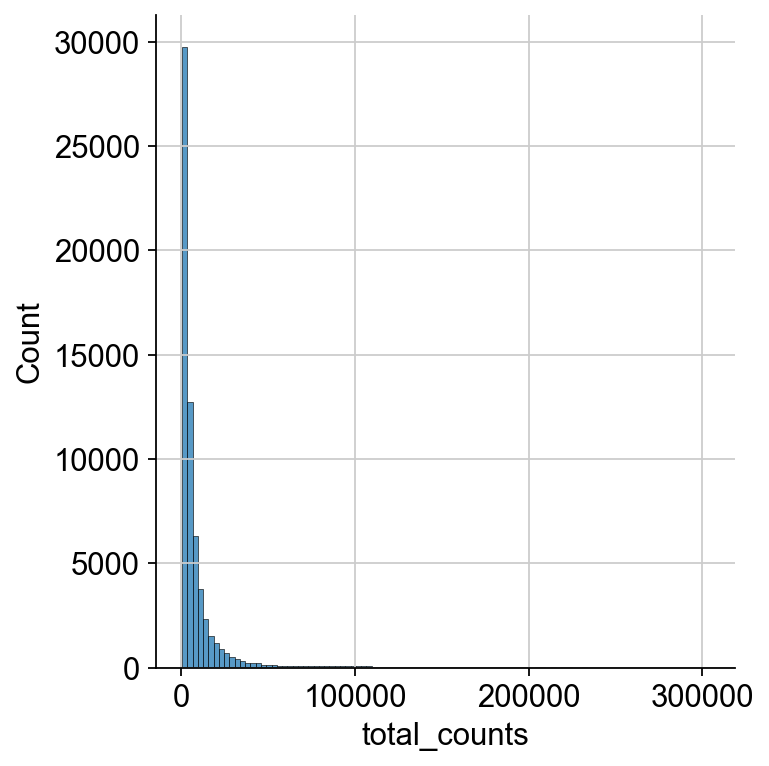

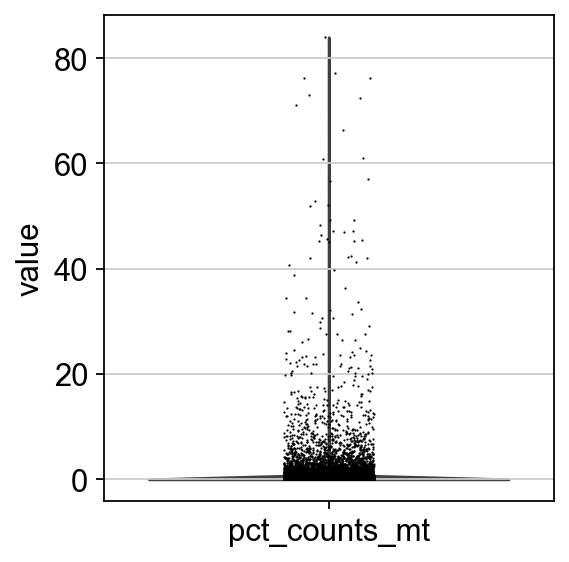

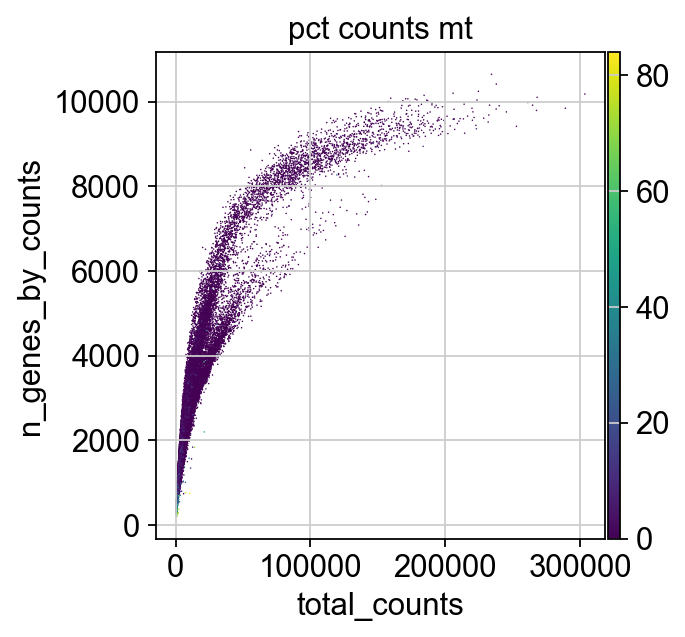

In [7]:
p1 = sns.displot(adata.obs["total_counts"], bins=100, kde=False)
# sc.pl.violin(adata, 'total_counts')
p2 = sc.pl.violin(adata, "pct_counts_mt")
p3 = sc.pl.scatter(adata, "total_counts", "n_genes_by_counts", color="pct_counts_mt")

Define outlier function

In [8]:
def is_outlier(adata, metric: str, nmads: int):
    M = adata.obs[metric]
    outlier = (M < np.median(M) - nmads * median_abs_deviation(M)) | (
        np.median(M) + nmads * median_abs_deviation(M) < M
    )
    return outlier


Compute outliers in three metrics

In [9]:
adata.obs["outlier"] = (
    is_outlier(adata, "log1p_total_counts", 5)
    | is_outlier(adata, "log1p_n_genes_by_counts", 5)
    | is_outlier(adata, "pct_counts_in_top_20_genes", 5)
)
adata.obs.outlier.value_counts()

False    62973
True       554
Name: outlier, dtype: int64

Compute mitochondrial gene outliers

In [10]:
adata.obs["mt_outlier"] = is_outlier(adata, "pct_counts_mt", 3) | (
    adata.obs["pct_counts_mt"] > 20
)
adata.obs.mt_outlier.value_counts()

False    49734
True     13793
Name: mt_outlier, dtype: int64

Filter anndata

In [11]:
print(f"Total number of cells: {adata.n_obs}")
adata = adata[(~adata.obs.outlier) & (~adata.obs.mt_outlier)].copy()

print(f"Number of cells after filtering of low quality cells: {adata.n_obs}")

Total number of cells: 63527


Number of cells after filtering of low quality cells: 49571


Plot filtered data

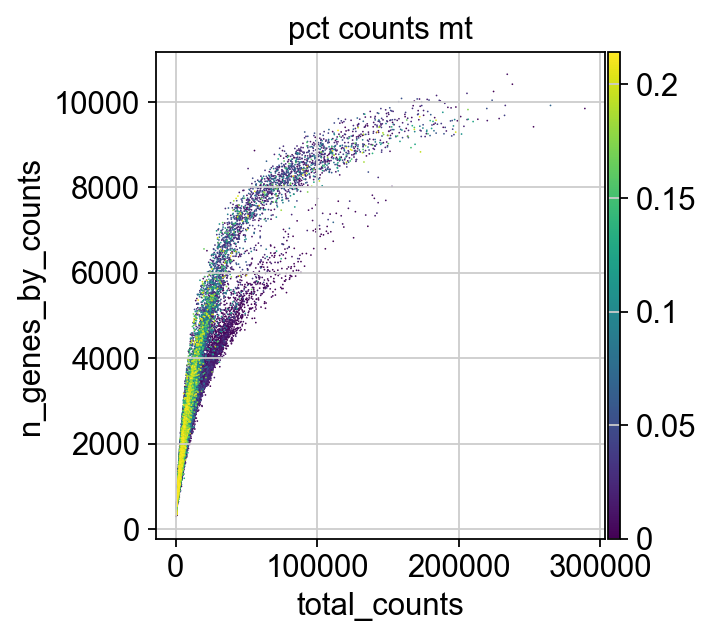

In [12]:
p1 = sc.pl.scatter(adata, "total_counts", "n_genes_by_counts", color="pct_counts_mt")

Load Python and R packages needed for SoupX

In [13]:
import logging

import anndata2ri
import rpy2.rinterface_lib.callbacks as rcb
import rpy2.robjects as ro

rcb.logger.setLevel(logging.ERROR)
ro.pandas2ri.activate()
anndata2ri.activate()

%load_ext rpy2.ipython

In [14]:
%%R
library(SoupX)


    an issue that caused a segfault when used with rpy2:
    https://github.com/rstudio/reticulate/pull/1188
    Make sure that you use a version of that package that includes
    the fix.
    

Copy AnnData object, normalize it, and log1p transform it

In [15]:
adata_pp = adata.copy()
sc.pp.normalize_per_cell(adata_pp)
sc.pp.log1p(adata_pp)

Compute principle components, generate neighborhood graph, and run leiden clustering on KNN-graph, saving clusters as a vector

In [16]:
sc.pp.pca(adata_pp)
sc.pp.neighbors(adata_pp)
sc.tl.leiden(adata_pp, key_added="soupx_groups")

# Preprocess variables for SoupX
soupx_groups = adata_pp.obs["soupx_groups"]

/opt/anaconda3/envs/scanpy_2025/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/var/folders/cr/_x68zjtj609_q0g6w5fq4mt00000gn/T/ipykernel_9142/1913318786.py:3: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata_pp, key_added="soupx_groups")


Delete copy of AnnData object to save memory

In [18]:
del adata_pp

Save and format filtered data for SoupX

In [20]:
cells = adata.obs_names
genes = adata.var_names
data = adata.X.T

Reload raw data and transpose for SoupX

In [22]:
adata_raw = sc.read_h5ad(path_final)
data_tod = adata_raw.X.T
del adata_raw

Construct SoupChannel and add metadata

In [23]:
%%R -i data -i data_tod -i genes -i cells -i soupx_groups -o out 

# specify row and column names of data
rownames(data) = genes
colnames(data) = cells
# ensure correct sparse format for table of counts and table of droplets
data <- as(data, "sparseMatrix")
data_tod <- as(data_tod, "sparseMatrix")

# Generate SoupChannel Object for SoupX 
sc = SoupChannel(data_tod, data, calcSoupProfile = FALSE)

# Add extra meta data to the SoupChannel object
soupProf = data.frame(row.names = rownames(data), est = rowSums(data)/sum(data), counts = rowSums(data))
sc = setSoupProfile(sc, soupProf)
# Set cluster information in SoupChannel
sc = setClusters(sc, soupx_groups)

# Estimate contamination fraction
sc  = autoEstCont(sc, doPlot=FALSE)
# Infer corrected table of counts and round to integer
out = adjustCounts(sc, roundToInt = TRUE)

Overwrite .X with SoupX corrected matrix

In [24]:
adata.layers["counts"] = adata.X
adata.layers["soupX_counts"] = out.T
adata.X = adata.layers["soupX_counts"]

Filter out genes not detected in at least 20 cells

In [25]:
print(f"Total number of genes: {adata.n_vars}")

# Min 20 cells - filters out 0 count genes
sc.pp.filter_genes(adata, min_cells=20)
print(f"Number of genes after cell filter: {adata.n_vars}")

Total number of genes: 19971
Number of genes after cell filter: 14656


Load more R packages for doublet detection

In [28]:
%%R
library(Seurat)
library(scater)
library(scDblFinder)
library(BiocParallel)

In [29]:
data_mat = adata.X.T

Run scDblFinder with data_mat as input

In [30]:
%%R -i data_mat -o doublet_score -o doublet_class

set.seed(123)
sce = scDblFinder(
    SingleCellExperiment(
        list(counts=data_mat),
    ) 
)
doublet_score = sce$scDblFinder.score
doublet_class = sce$scDblFinder.class

Add outputs of scDblFinder to our AnnData object

In [31]:
adata.obs["scDblFinder_score"] = doublet_score
adata.obs["scDblFinder_class"] = doublet_class
adata.obs.scDblFinder_class.value_counts()

singlet    37666
doublet    11905
Name: scDblFinder_class, dtype: int64

Save our data set

In [32]:
adata.write(os.path.join(path_results, "liver_qc.h5ad"))